# Análisis Exploratorio

### **Objetivo 1: Análisis Descriptivo Inicial**
- Estudio estadístico elemental de las variables
- Identificación de tipos de datos (fecha, carácter, categóricos, numéricos, etc.)
- Detección de valores nulos
- Identificación de outliers y anomalías

---

### **ÍNDICE DE CONTENIDOS**

#### **EXPLORATORY DATA ANALYSIS (EDA)**
Importación de Librerías y Configuración Inicial
Carga Dataset
1. Análisis de Variables Numéricas
- Análisis General
- Estadísticas de las Variables Numéricas
- Visualización de las Estadísticas
- Detección de Valores Nulos
- Identificación de outliers y anomalías

2. Análisis de Variables Categóricas
- Estadísticas de las Variables Categóricas
- Detección de Valores Nulos



# EXPLORATORY DATA ANALYSIS (EDA)


## Importación de Librerías y Configuración Inicial

In [24]:
# ============================================================================
# CONFIGURACIÓN PARA EDA - ANÁLISIS EXPLORATORIO DE DATOS
# ============================================================================

import pandas as pd
import numpy as np

# Librerías para visualización avanzada
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Análisis estadístico avanzado
from scipy import stats
from scipy.stats import chi2_contingency, normaltest, jarque_bera, shapiro
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Configuración de estilo para visualizaciones profesionales
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Configuración adicional para pandas en EDA
pd.set_option('display.precision', 3)

print("🔍 CONFIGURACIÓN EDA COMPLETADA")
print("="*50)
print("✅ Librerías de visualización cargadas")
print("✅ Herramientas estadísticas preparadas") 
print("✅ Configuración de gráficos optimizada")
print("📊 Listo para análisis exploratorio avanzado")


🔍 CONFIGURACIÓN EDA COMPLETADA
✅ Librerías de visualización cargadas
✅ Herramientas estadísticas preparadas
✅ Configuración de gráficos optimizada
📊 Listo para análisis exploratorio avanzado


## Carga del Dataset

In [48]:
file_path = '../raw_data/salud_mental_cleaned.csv'
df = pd.read_csv(file_path)

## Análisis de Variables Numéricas

### Análisis General

#### Estadísticas de las Variables Numéricas

In [26]:
def obtener_estadisticas_numericas(columnas_numericas):
    """
    Crea un diccionario con las variables numéricas y sus propiedades estadísticas.
    
    Args:
        df: DataFrame de pandas
        
    Returns:
        dict: Diccionario donde las claves son nombres de columnas y los valores son 
              diccionarios con estadísticas descriptivas
    """
    
    estadisticas_map = {}
    
    for columna in columnas_numericas:
        # Verificar si la columna está completamente vacía o tiene solo valores nulos
        if df[columna].dropna().empty:
            estadisticas_map[columna] = {
                'media': None,
                'mediana': None,
                'moda': None,
                'desviacion_estandar': None,
                'varianza': None,
                'minimo': None,
                'maximo': None,
                'rango': None,
                'q1': None,
                'q3': None,
                'iqr': None,
                'valores_nulos': df[columna].isnull().sum(),
                'valores_unicos': 0,
                'asimetria': None,
                'curtosis': None
            }
            continue
        
        # Calcular estadísticas solo si hay datos válidos
        estadisticas_map[columna] = {
            'media': df[columna].mean(),
            'mediana': df[columna].median(),
            'moda': df[columna].mode()[0] if not df[columna].mode().empty else None,
            'desviacion_estandar': df[columna].std(),
            'varianza': df[columna].var(),
            'minimo': df[columna].min(),
            'maximo': df[columna].max(),
            'rango': df[columna].max() - df[columna].min(),
            'q1': df[columna].quantile(0.25),
            'q3': df[columna].quantile(0.75),
            'iqr': df[columna].quantile(0.75) - df[columna].quantile(0.25),
            'valores_nulos': df[columna].isnull().sum(),
            'valores_unicos': df[columna].nunique(),
            'asimetria': df[columna].skew(),
            'curtosis': df[columna].kurtosis()
        }
    
    return estadisticas_map

In [ ]:
columnas_numercias = df.select_dtypes(include=[np.number]).columns
estadisticas = obtener_estadisticas_numericas(columnas_numercias)

#### Visualización de las Estadísticas

In [44]:
def visualizar_estadisticas(estadisticas_map):
    """
    Crea visualizaciones profesionales de las estadísticas de variables numéricas
    Excluye variables sin valores válidos de gráficos principales
    """
    # Preparar datos para visualización
    vars_numericas = list(estadisticas_map.keys())
    n_vars = len(vars_numericas)
    
    if n_vars == 0:
        print("⚠️ No hay variables numéricas para visualizar")
        return
    
    # Filtrar variables que tienen al menos un valor válido
    vars_con_datos = []
    vars_sin_datos = []
    
    for var in vars_numericas:
        # Contar valores no nulos en el dataframe original
        valores_validos = df[var].notna().sum()
        if valores_validos > 0:
            vars_con_datos.append(var)
        else:
            vars_sin_datos.append(var)
    
    
    # ========================================================================
    # VISUALIZACIÓN 1: Dashboard de Estadísticas Descriptivas
    # ========================================================================
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle('Dashboard de Estadísticas Descriptivas', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    # DataFrame para medidas de tendencia central (SOLO VARIABLES CON DATOS)
    if vars_con_datos:
        df_central = pd.DataFrame({
            var: {
                'Media': estadisticas_map[var]['media'],
                'Mediana': estadisticas_map[var]['mediana'],
                'Moda': estadisticas_map[var]['moda'] if estadisticas_map[var]['moda'] is not None else np.nan
            } for var in vars_con_datos
        }).T
        
        # 1.1 Heatmap de Tendencia Central
        sns.heatmap(df_central, annot=True, fmt='.2f', cmap='YlOrRd', 
                    ax=axes[0, 0], cbar_kws={'label': 'Valor'})
        axes[0, 0].set_title('Medidas de Tendencia Central', 
                             fontweight='bold', fontsize=14)
        axes[0, 0].set_xlabel('')
        axes[0, 0].set_ylabel('Variables', fontweight='bold')
    else:
        axes[0, 0].text(0.5, 0.5, 'No hay variables con datos válidos', 
                       ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Medidas de Tendencia Central', 
                             fontweight='bold', fontsize=14)
    
    # DataFrame para medidas de dispersión (SOLO VARIABLES CON DATOS)
    if vars_con_datos:
        df_dispersion = pd.DataFrame({
            var: {
                'Desv. Est.': estadisticas_map[var]['desviacion_estandar'],
                'Varianza': estadisticas_map[var]['varianza'],
                'IQR': estadisticas_map[var]['iqr'],
                'Rango': estadisticas_map[var]['rango']
            } for var in vars_con_datos
        }).T
        
        # 1.2 Heatmap de Dispersión
        sns.heatmap(df_dispersion, annot=True, fmt='.2f', cmap='Blues', 
                    ax=axes[0, 1], cbar_kws={'label': 'Valor'})
        axes[0, 1].set_title('Medidas de Dispersión', 
                             fontweight='bold', fontsize=14)
        axes[0, 1].set_xlabel('')
        axes[0, 1].set_ylabel('Variables', fontweight='bold')
    else:
        axes[0, 1].text(0.5, 0.5, 'No hay variables con datos válidos', 
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Medidas de Dispersión', 
                             fontweight='bold', fontsize=14)
    
    # 1.3 Gráfico de Asimetría y Curtosis (SOLO VARIABLES CON DATOS)
    if vars_con_datos:
        df_forma = pd.DataFrame({
            'Variable': vars_con_datos,
            'Asimetría': [estadisticas_map[var]['asimetria'] for var in vars_con_datos],
            'Curtosis': [estadisticas_map[var]['curtosis'] for var in vars_con_datos]
        })
        
        x_pos = np.arange(len(vars_con_datos))
        width = 0.35
        
        bars1 = axes[1, 0].bar(x_pos - width/2, df_forma['Asimetría'], 
                              width, label='Asimetría', alpha=0.8, color='#FF6B6B')
        bars2 = axes[1, 0].bar(x_pos + width/2, df_forma['Curtosis'], 
                              width, label='Curtosis', alpha=0.8, color='#4ECDC4')
        
        axes[1, 0].set_xlabel('Variables', fontweight='bold')
        axes[1, 0].set_ylabel('Valor', fontweight='bold')
        axes[1, 0].set_title('Forma de la Distribución', 
                             fontweight='bold', fontsize=14)
        axes[1, 0].set_xticks(x_pos)
        axes[1, 0].set_xticklabels(vars_con_datos, rotation=45, ha='right')
        axes[1, 0].legend()
        axes[1, 0].grid(axis='y', alpha=0.3)
        axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        
        # Añadir valores sobre las barras
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                               f'{height:.2f}', ha='center', 
                               va='bottom' if height > 0 else 'top', fontsize=9)
    else:
        axes[1, 0].text(0.5, 0.5, 'No hay variables con datos válidos', 
                       ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('📐 Forma de la Distribución', 
                             fontweight='bold', fontsize=14)
    
    # 1.4 Calidad de Datos (TODAS LAS VARIABLES, pero filtrar las que tienen 0% nulos)
    valores_nulos = [estadisticas_map[var]['valores_nulos'] for var in vars_numericas]
    total_registros = len(df)
    
    pct_nulos = [(nulos / total_registros * 100) if total_registros > 0 else 0 
                 for nulos in valores_nulos]
    
    # Filtrar variables que tienen algún valor nulo (>0%)
    vars_con_nulos = []
    pct_nulos_filtrados = []
    
    for var, pct in zip(vars_numericas, pct_nulos):
        if pct > 0:  # Solo mostrar variables con valores nulos
            vars_con_nulos.append(var)
            pct_nulos_filtrados.append(pct)
    
    if vars_con_nulos:
        colors = ['#2ECC71' if pct < 5 else '#F39C12' if pct < 15 else '#E74C3C' 
                  for pct in pct_nulos_filtrados]
        
        bars = axes[1, 1].barh(vars_con_nulos, pct_nulos_filtrados, color=colors, alpha=0.8)
        axes[1, 1].set_xlabel('Porcentaje de Valores Nulos (%)', fontweight='bold')
        axes[1, 1].set_title('Completitud de Datos', 
                             fontweight='bold', fontsize=14)
        axes[1, 1].grid(axis='x', alpha=0.3)
        
        # Añadir valores en las barras
        for i, (bar, pct) in enumerate(zip(bars, pct_nulos_filtrados)):
            axes[1, 1].text(pct + 0.5, i, f'{pct:.1f}%', 
                           va='center', fontweight='bold', fontsize=10)
    else:
        axes[1, 1].text(0.5, 0.5, 'Todas las variables tienen 0% de valores nulos', 
                       ha='center', va='center', transform=axes[1, 1].transAxes,
                       fontsize=12, fontweight='bold')
        axes[1, 1].set_title('Completitud de Datos', 
                             fontweight='bold', fontsize=14)
        axes[1, 1].set_xlabel('Porcentaje de Valores Nulos (%)', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('dashboard_estadisticas_descriptivas.png', dpi=300, bbox_inches='tight')
    print("✅ Guardado: dashboard_estadisticas_descriptivas.png")
    
    # Resumen adicional
    print(f"\n📊 RESUMEN DE VISUALIZACIÓN:")
    print(f"   • Variables con datos: {len(vars_con_datos)}/{n_vars}")
    print(f"   • Variables sin datos: {len(vars_sin_datos)}/{n_vars}")
    print(f"   • Variables con valores nulos (>0%): {len(vars_con_nulos)}/{n_vars}")
    
    plt.show()

✅ Guardado: dashboard_estadisticas_descriptivas.png

📊 RESUMEN DE VISUALIZACIÓN:
   • Variables con datos: 19/33
   • Variables sin datos: 14/33
   • Variables con valores nulos (>0%): 15/33


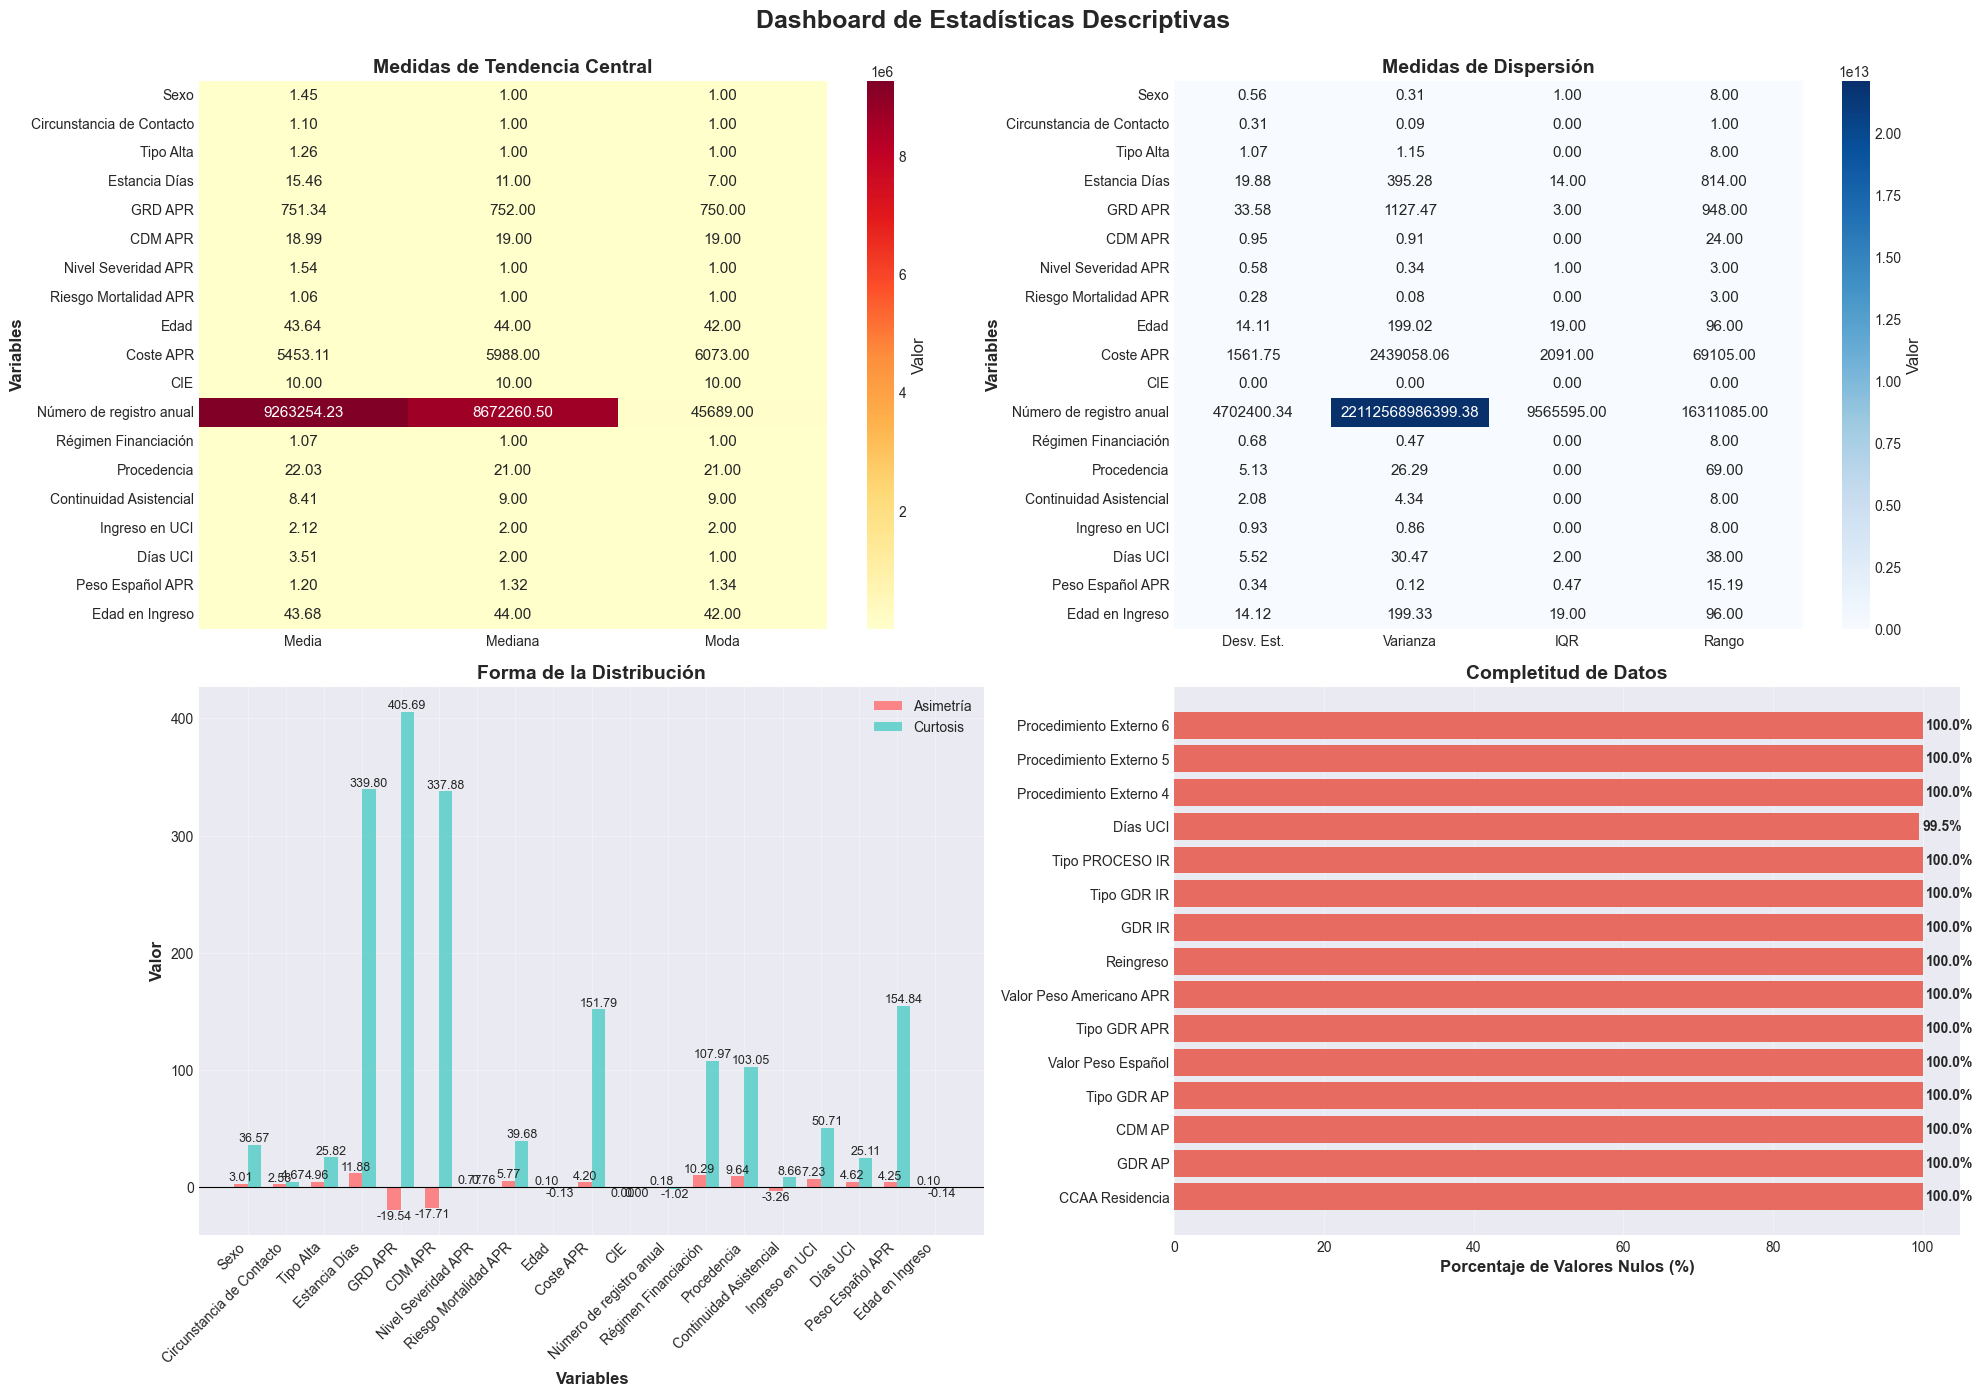

In [45]:
visualizar_estadisticas(estadisticas)

### Detección de Valores Nulos

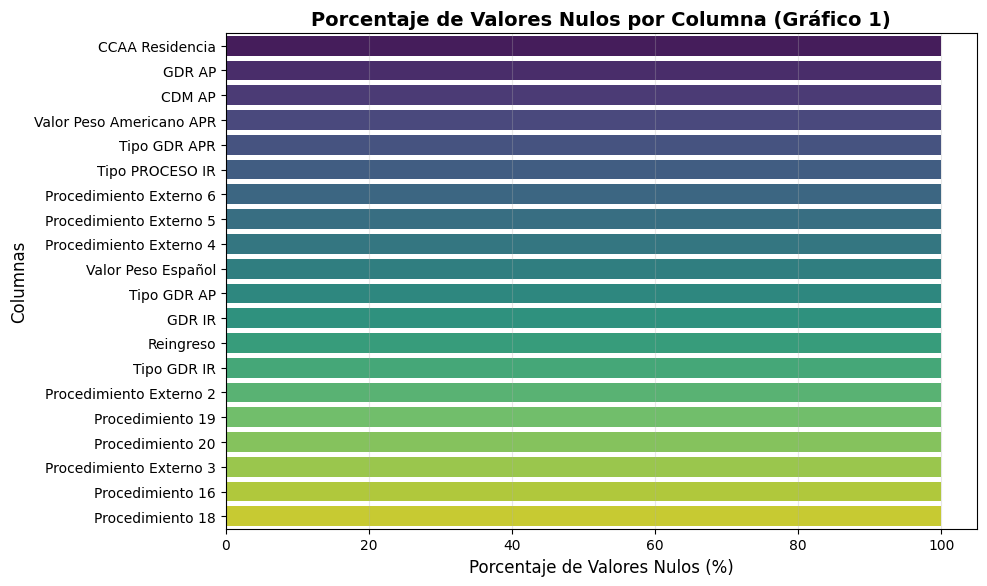

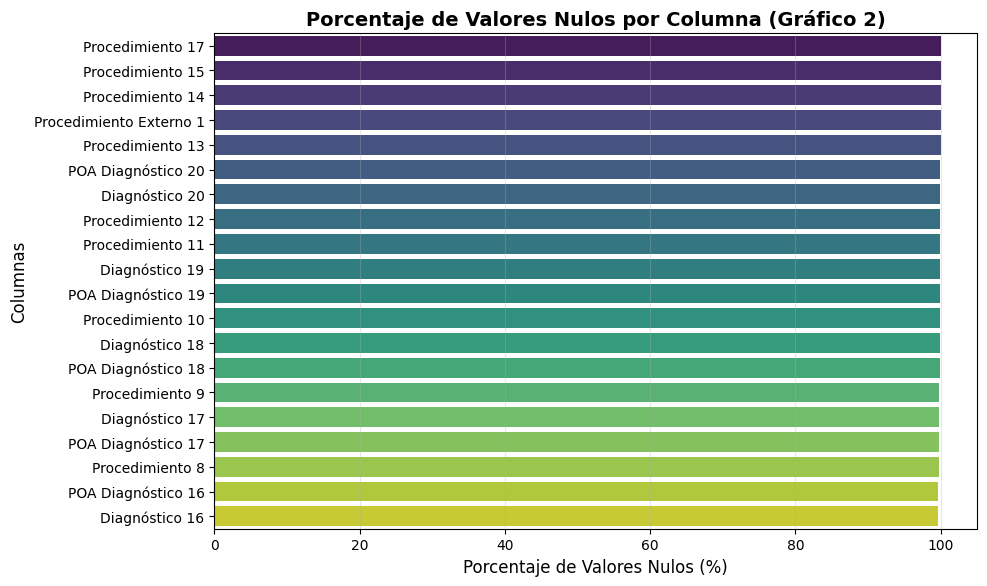

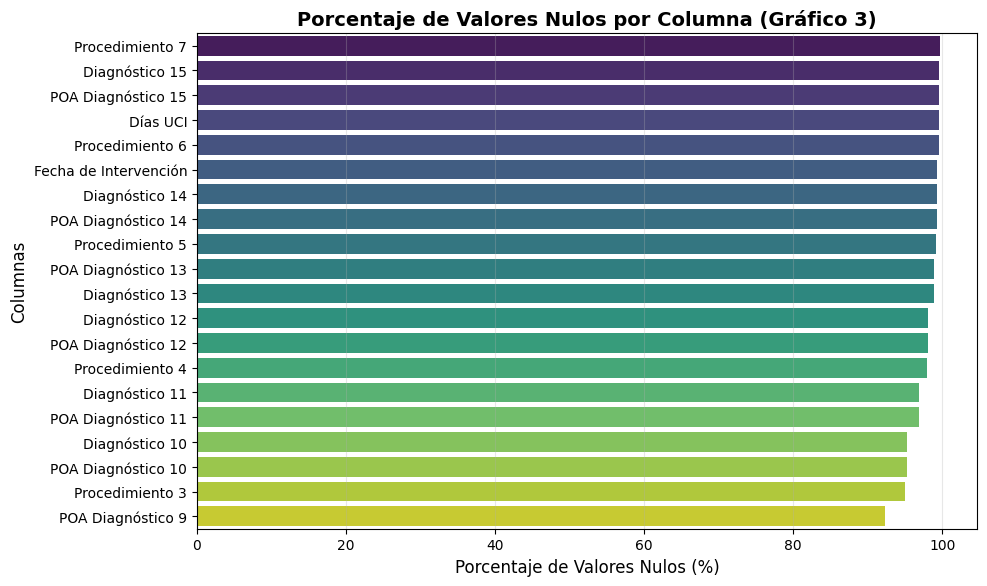

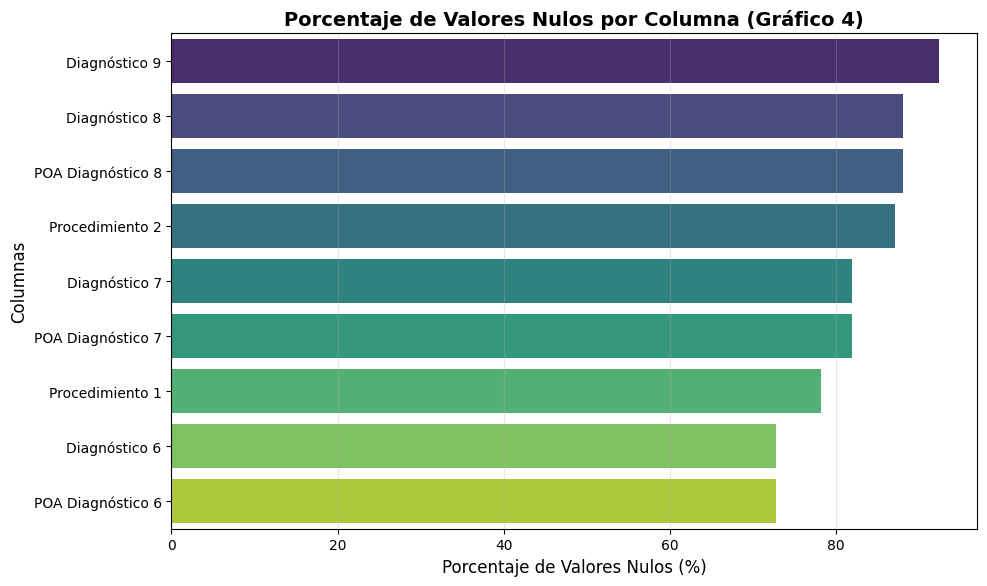

In [33]:
# Función para filtrar columnas según el porcentaje de valores nulos
def plot_missing_values(df, threshold=0):
    """
    Genera gráficos de columnas con valores nulos según un umbral de porcentaje.
    
    Args:
        df (DataFrame): Dataset a analizar.
        threshold (int): Porcentaje de valores nulos a partir del cual se consideran relevantes.
    """
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_data = missing_percentage[missing_percentage > threshold].sort_values(ascending=False)

    # Dividir las columnas en grupos para mejorar la visualización
    columns_per_plot = 20  # Número de columnas por gráfico
    num_plots = (len(missing_data) + columns_per_plot - 1) // columns_per_plot  # Calcular número de gráficos

    for i in range(num_plots):
        start_idx = i * columns_per_plot
        end_idx = start_idx + columns_per_plot
        subset_missing_data = missing_data.iloc[start_idx:end_idx]
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=subset_missing_data.values, y=subset_missing_data.index, palette="viridis", hue=subset_missing_data.index, dodge=False)
        plt.title(f"Porcentaje de Valores Nulos por Columna (Gráfico {i + 1})", fontsize=14, fontweight="bold")
        plt.xlabel("Porcentaje de Valores Nulos (%)")
        plt.ylabel("Columnas")
        plt.tight_layout()
        plt.savefig(f"valores_nulos_por_columna_{i + 1}.png")
        plt.show()

# ============================================================================
# FILTRADO DE VARIABLES NUMÉRICAS POR PORCENTAJE DE NULOS
# ============================================================================

def filter_numeric_columns_by_nulls(df, max_null_percentage):
    """
    Filtra columnas numéricas con un porcentaje de valores nulos menor al umbral especificado.

    Args:
        df (pd.DataFrame): DataFrame que contiene las columnas numéricas.
        max_null_percentage (float): Porcentaje máximo de valores nulos permitido (0-100).

    Returns:
        list: Lista de columnas numéricas que cumplen con el criterio.
    """
    # Seleccionar columnas numéricas
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Filtrar columnas según el porcentaje de valores nulos
    filtered_columns = [
        col for col in numeric_columns
        if (df[col].isnull().sum() / len(df)) * 100 <= max_null_percentage
    ]
    return filtered_columns

threshold = 70

# Identificar columnas con valores nulos y calcular el porcentaje
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Llamar a la función con el umbral deseado
plot_missing_values(df, threshold=threshold)

columnas_numericas_sin_nulos = filter_numeric_columns_by_nulls(df, max_null_percentage=threshold)



### Identificación de outliers y anomalías

In [42]:
# ============================================================================
# DETECCIÓN AVANZADA DE OUTLIERS - ESTÁNDAR INDUSTRIAL
# ============================================================================



def detect_outliers_comprehensive(df, numeric_columns, max_null_percentage=20):
    """
    Detección industrial de outliers usando 5 métodos diferentes
    FILTRADO: Solo analiza columnas con porcentaje de nulos <= max_null_percentage
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame con los datos a analizar
    numeric_columns : list
        Lista de nombres de columnas numéricas a analizar
    max_null_percentage : float, default=20
        Porcentaje máximo de valores nulos permitido (0-100)
        Columnas con más nulos que este umbral serán excluidas
    
    Métodos implementados:
    1. IQR (Interquartile Range) - Método clásico de Tukey
    2. Z-Score - Basado en desviación estándar
    3. Modified Z-Score (MAD) - Robusto a outliers extremos
    4. Isolation Forest - Machine Learning
    5. Elliptic Envelope - Covarianza robusta
    """
    
    print("DETECCIÓN AVANZADA DE OUTLIERS - ANÁLISIS INDUSTRIAL")
    print("="*80)
    
    outlier_results = {}
    
    # Filtrar columnas numéricas según porcentaje de nulos
    filtered_columns = []
    excluded_columns = []
    
    for col in numeric_columns:
        if col not in df.columns:
            continue
        
        null_percentage = (df[col].isnull().sum() / len(df)) * 100
        
        if null_percentage <= max_null_percentage:
            filtered_columns.append(col)
        else:
            excluded_columns.append((col, null_percentage))
    
    # Mostrar resumen del filtrado
    print(f"\n📊 RESUMEN DE FILTRADO:")
    print(f"   • Columnas totales: {len(numeric_columns)}")
    print(f"   • Columnas analizadas: {len(filtered_columns)}")
    print(f"   • Columnas excluidas: {len(excluded_columns)}")
    
    if excluded_columns:
        print(f"\n⚠️ COLUMNAS EXCLUIDAS (>{max_null_percentage}% nulos):")
        for col, pct in excluded_columns:
            print(f"   • {col}: {pct:.2f}% nulos")
    
    # Analizar solo las columnas filtradas
    for col in filtered_columns:
        if col not in df.columns:
            continue
            
        data = df[col].dropna()
        
        if len(data) < 10:
            print(f"⚠️ {col}: Insuficientes datos para análisis")
            continue
        
        print(f"\n📊 Analizando: {col}")
        print("-" * 60)
        
        outliers_dict = {}
        
        # ========================================================================
        # MÉTODO 1: IQR (Interquartile Range) - TUKEY'S FENCES
        # ========================================================================
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        
        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR
        
        outliers_iqr = data[(data < lower_fence) | (data > upper_fence)]
        outliers_dict['IQR'] = {
            'indices': outliers_iqr.index.tolist(),
            'count': len(outliers_iqr),
            'percentage': len(outliers_iqr) / len(data) * 100,
            'bounds': (lower_fence, upper_fence)
        }
        
        # ========================================================================
        # MÉTODO 2: Z-SCORE (DESVIACIÓN ESTÁNDAR)
        # ========================================================================
        z_scores = np.abs(stats.zscore(data))
        outliers_zscore = data[z_scores > 3]
        outliers_dict['Z-Score'] = {
            'indices': outliers_zscore.index.tolist(),
            'count': len(outliers_zscore),
            'percentage': len(outliers_zscore) / len(data) * 100,
            'threshold': 3
        }
        
        # ========================================================================
        # MÉTODO 3: MODIFIED Z-SCORE (MAD - Median Absolute Deviation)
        # ========================================================================
        median = np.median(data)
        mad = np.median(np.abs(data - median))
        
        if mad != 0:
            modified_z_scores = 0.6745 * (data - median) / mad
            outliers_mad = data[np.abs(modified_z_scores) > 3.5]
        else:
            outliers_mad = pd.Series(dtype=float)
            
        outliers_dict['MAD'] = {
            'indices': outliers_mad.index.tolist(),
            'count': len(outliers_mad),
            'percentage': len(outliers_mad) / len(data) * 100,
            'threshold': 3.5
        }
        
        # ========================================================================
        # MÉTODO 4: ISOLATION FOREST (MACHINE LEARNING)
        # ========================================================================
        iso_forest = IsolationForest(
            contamination=0.1,
            random_state=42,
            n_estimators=100
        )
        
        outlier_labels = iso_forest.fit_predict(data.values.reshape(-1, 1))
        outliers_isolation = data[outlier_labels == -1]
        
        outliers_dict['Isolation Forest'] = {
            'indices': outliers_isolation.index.tolist(),
            'count': len(outliers_isolation),
            'percentage': len(outliers_isolation) / len(data) * 100,
            'contamination': 0.1
        }
        
        # ========================================================================
        # MÉTODO 5: ELLIPTIC ENVELOPE (COVARIANZA ROBUSTA)
        # ========================================================================
        if len(data) >= 20:
            try:
                envelope = EllipticEnvelope(contamination=0.1, random_state=42)
                outlier_labels_env = envelope.fit_predict(data.values.reshape(-1, 1))
                outliers_envelope = data[outlier_labels_env == -1]
                
                outliers_dict['Elliptic Envelope'] = {
                    'indices': outliers_envelope.index.tolist(),
                    'count': len(outliers_envelope),
                    'percentage': len(outliers_envelope) / len(data) * 100,
                    'contamination': 0.1
                }
            except:
                outliers_dict['Elliptic Envelope'] = {
                    'indices': [],
                    'count': 0,
                    'percentage': 0,
                    'contamination': 0.1
                }
        
        # ========================================================================
        # CONSENSO DE MÉTODOS
        # ========================================================================
        all_outlier_indices = set()
        for method_data in outliers_dict.values():
            all_outlier_indices.update(method_data['indices'])
        
        # Contar en cuántos métodos aparece cada índice
        consensus_outliers = []
        for idx in all_outlier_indices:
            count = sum(1 for method_data in outliers_dict.values() 
                       if idx in method_data['indices'])
            if count >= 3:  # Consenso: aparece en al menos 3 métodos
                consensus_outliers.append(idx)
        
        outliers_dict['Consensus (≥3 methods)'] = {
            'indices': consensus_outliers,
            'count': len(consensus_outliers),
            'percentage': len(consensus_outliers) / len(data) * 100
        }
        
        # Imprimir resumen
        print(f"📈 Resultados por método:")
        for method, info in outliers_dict.items():
            print(f"   • {method:<25}: {info['count']:>4} outliers ({info['percentage']:>5.2f}%)")
        
        outlier_results[col] = {
            'data': data,
            'methods': outliers_dict,
            'total_observations': len(data)
        }
    
    return outlier_results


# Ejecutar detección
outlier_analysis = detect_outliers_comprehensive(df, columnas_numercias, max_null_percentage=70)

DETECCIÓN AVANZADA DE OUTLIERS - ANÁLISIS INDUSTRIAL

📊 RESUMEN DE FILTRADO:
   • Columnas totales: 33
   • Columnas analizadas: 18
   • Columnas excluidas: 15

⚠️ COLUMNAS EXCLUIDAS (>70% nulos):
   • CCAA Residencia: 100.00% nulos
   • GDR AP: 100.00% nulos
   • CDM AP: 100.00% nulos
   • Tipo GDR AP: 100.00% nulos
   • Valor Peso Español: 100.00% nulos
   • Tipo GDR APR: 100.00% nulos
   • Valor Peso Americano APR: 100.00% nulos
   • Reingreso: 100.00% nulos
   • GDR IR: 100.00% nulos
   • Tipo GDR IR: 100.00% nulos
   • Tipo PROCESO IR: 100.00% nulos
   • Días UCI: 99.53% nulos
   • Procedimiento Externo 4: 100.00% nulos
   • Procedimiento Externo 5: 100.00% nulos
   • Procedimiento Externo 6: 100.00% nulos

📊 Analizando: Sexo
------------------------------------------------------------
📈 Resultados por método:
   • IQR                      :   25 outliers ( 0.12%)
   • Z-Score                  :   25 outliers ( 0.12%)
   • MAD                      :    0 outliers ( 0.00%)
   • Iso


📈 ANÁLISIS CON UMBRAL PERMISIVO (≤70% nulos):
📊 BOXPLOTS DE VARIABLES NUMÉRICAS (FILTRADAS POR NULOS)
🔍 Filtro aplicado: Porcentaje máximo de nulos = 70%

📊 RESUMEN DE FILTRADO:
   • Columnas numéricas totales: 33
   • Columnas a graficar: 18
   • Columnas excluidas: 15

⚠️ COLUMNAS EXCLUIDAS (>70% nulos):
   • CCAA Residencia: 100.00% nulos
   • GDR AP: 100.00% nulos
   • CDM AP: 100.00% nulos
   • Tipo GDR AP: 100.00% nulos
   • Valor Peso Español: 100.00% nulos
   • Tipo GDR APR: 100.00% nulos
   • Valor Peso Americano APR: 100.00% nulos
   • Reingreso: 100.00% nulos
   • GDR IR: 100.00% nulos
   • Tipo GDR IR: 100.00% nulos
   • Tipo PROCESO IR: 100.00% nulos
   • Días UCI: 99.53% nulos
   • Procedimiento Externo 4: 100.00% nulos
   • Procedimiento Externo 5: 100.00% nulos
   • Procedimiento Externo 6: 100.00% nulos

💾 Gráfico guardado: 'boxplots_filtered_max70pct_nulls.png'


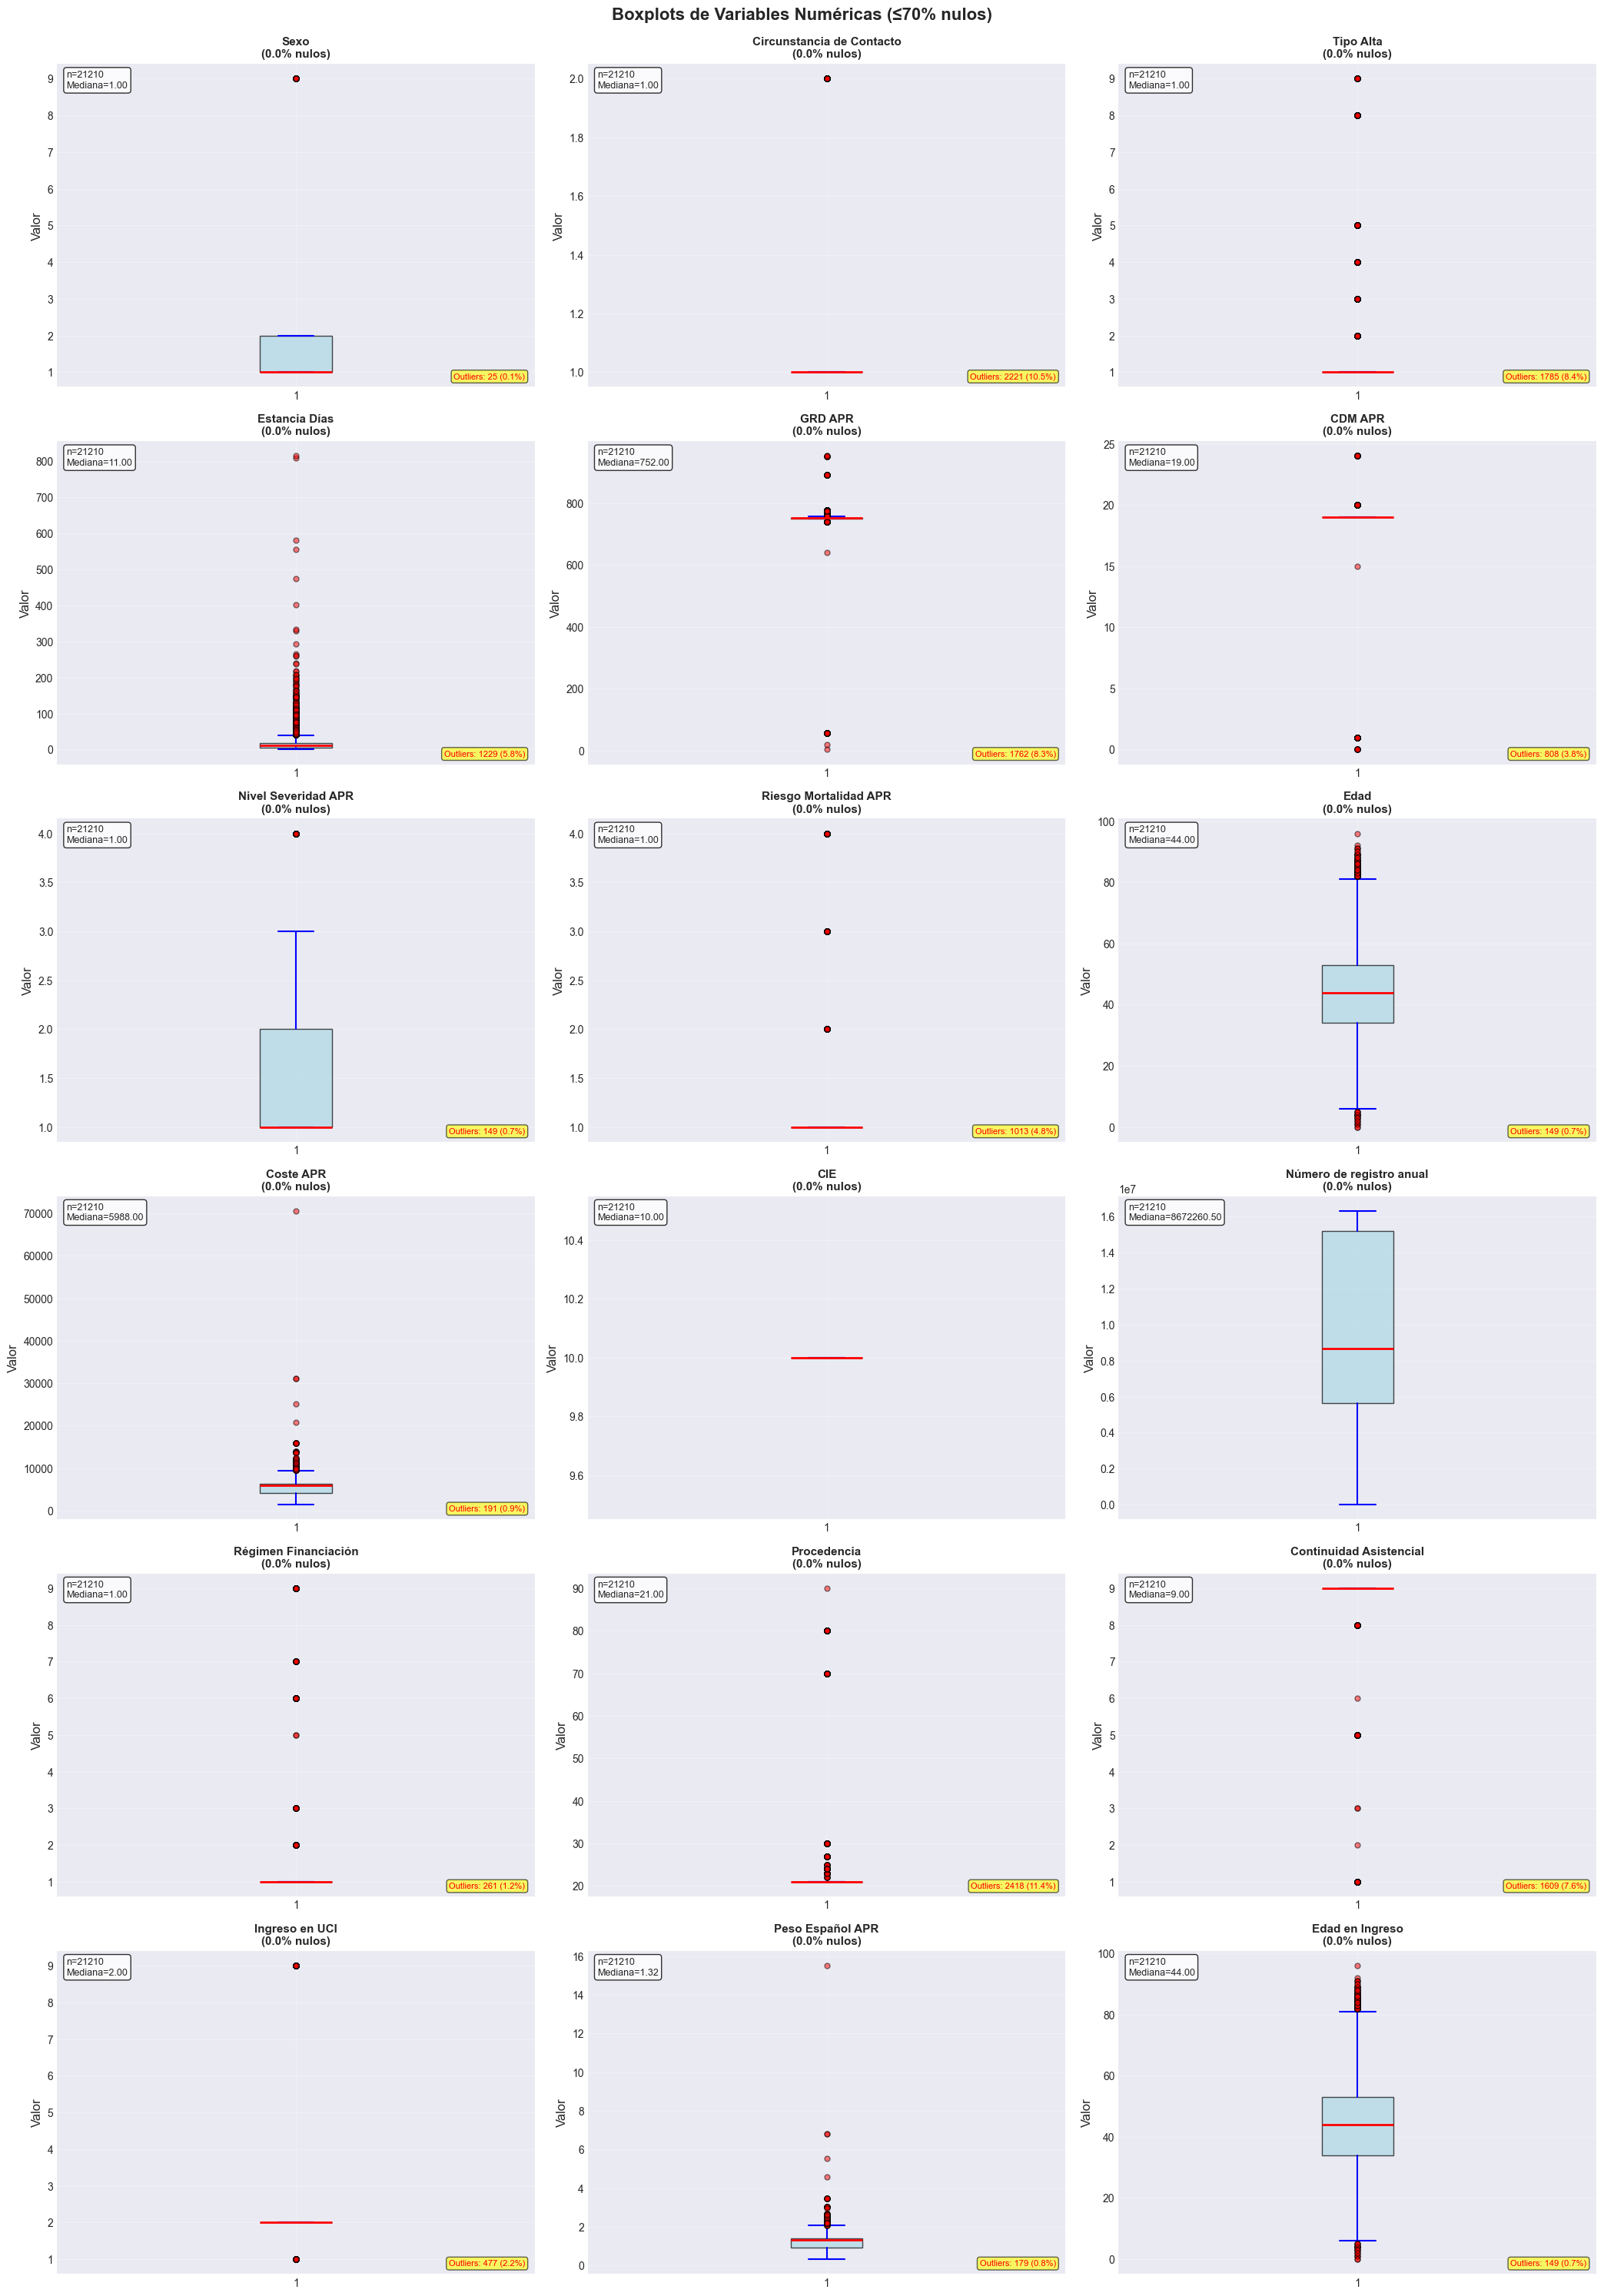


📊 RESUMEN DE OUTLIERS POR VARIABLE:
   • Sexo: 25 outliers (0.12%)
   • Circunstancia de Contacto: 2221 outliers (10.47%)
   • Tipo Alta: 1785 outliers (8.42%)
   • Estancia Días: 1229 outliers (5.79%)
   • GRD APR: 1762 outliers (8.31%)
   • CDM APR: 808 outliers (3.81%)
   • Nivel Severidad APR: 149 outliers (0.70%)
   • Riesgo Mortalidad APR: 1013 outliers (4.78%)
   • Edad: 149 outliers (0.70%)
   • Coste APR: 191 outliers (0.90%)
   • CIE: 0 outliers (0.00%)
   • Número de registro anual: 0 outliers (0.00%)
   • Régimen Financiación: 261 outliers (1.23%)
   • Procedencia: 2418 outliers (11.40%)
   • Continuidad Asistencial: 1609 outliers (7.59%)
   • Ingreso en UCI: 477 outliers (2.25%)
   • Peso Español APR: 179 outliers (0.84%)
   • Edad en Ingreso: 149 outliers (0.70%)


In [43]:
# ============================================================================
# BOXPLOTS DE VARIABLES NUMÉRICAS CON FILTRO DE NULOS
# ============================================================================

def plot_boxplots_filtered_by_nulls(df, max_null_percentage=20):
    """
    Genera boxplots para variables numéricas con porcentaje de nulos menor o igual al umbral
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame con los datos a analizar
    max_null_percentage : float, default=20
        Porcentaje máximo de valores nulos permitido (0-100)
    """
    print("📊 BOXPLOTS DE VARIABLES NUMÉRICAS (FILTRADAS POR NULOS)")
    print("="*70)
    print(f"🔍 Filtro aplicado: Porcentaje máximo de nulos = {max_null_percentage}%")
    print("="*70)
    
    # Seleccionar columnas numéricas
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Filtrar según porcentaje de nulos
    filtered_columns = []
    excluded_columns = []
    
    for col in numeric_columns:
        null_percentage = (df[col].isnull().sum() / len(df)) * 100
        
        if null_percentage <= max_null_percentage:
            filtered_columns.append(col)
        else:
            excluded_columns.append((col, null_percentage))
    
    # Mostrar resumen
    print(f"\n📊 RESUMEN DE FILTRADO:")
    print(f"   • Columnas numéricas totales: {len(numeric_columns)}")
    print(f"   • Columnas a graficar: {len(filtered_columns)}")
    print(f"   • Columnas excluidas: {len(excluded_columns)}")
    
    if excluded_columns:
        print(f"\n⚠️ COLUMNAS EXCLUIDAS (>{max_null_percentage}% nulos):")
        for col, pct in excluded_columns:
            print(f"   • {col}: {pct:.2f}% nulos")
    
    if not filtered_columns:
        print("\n❌ No hay columnas numéricas que cumplan el criterio")
        return
    
    # Determinar layout de subplots
    n_cols = min(3, len(filtered_columns))  # Máximo 3 columnas
    n_rows = (len(filtered_columns) + n_cols - 1) // n_cols
    
    # Crear figura con subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 5*n_rows))
    fig.suptitle(f'Boxplots de Variables Numéricas (≤{max_null_percentage}% nulos)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # Asegurar que axes sea siempre un array 2D
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Generar boxplots
    for idx, col in enumerate(filtered_columns):
        row = idx // n_cols
        col_idx = idx % n_cols
        ax = axes[row, col_idx]
        
        # Datos limpios (sin nulos)
        data_clean = df[col].dropna()
        
        if len(data_clean) == 0:
            ax.text(0.5, 0.5, 'Sin datos válidos', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(col, fontweight='bold')
            continue
        
        # Crear boxplot
        bp = ax.boxplot(data_clean, patch_artist=True, vert=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7),
                       medianprops=dict(color='red', linewidth=2),
                       whiskerprops=dict(color='blue', linewidth=1.5),
                       capprops=dict(color='blue', linewidth=1.5),
                       flierprops=dict(marker='o', markerfacecolor='red', 
                                     markersize=5, alpha=0.5))
        
        # Título y etiquetas
        null_pct = (df[col].isnull().sum() / len(df)) * 100
        ax.set_title(f'{col}\n({null_pct:.1f}% nulos)', fontweight='bold', fontsize=11)
        ax.set_ylabel('Valor')
        ax.grid(axis='y', alpha=0.3)
        
        # Estadísticas adicionales en el gráfico
        stats_text = f'n={len(data_clean)}\nMediana={data_clean.median():.2f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               verticalalignment='top', fontsize=9,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Calcular y mostrar outliers
        Q1 = data_clean.quantile(0.25)
        Q3 = data_clean.quantile(0.75)
        IQR = Q3 - Q1
        outliers = data_clean[(data_clean < Q1 - 1.5*IQR) | (data_clean > Q3 + 1.5*IQR)]
        
        if len(outliers) > 0:
            outlier_pct = len(outliers) / len(data_clean) * 100
            outlier_text = f'Outliers: {len(outliers)} ({outlier_pct:.1f}%)'
            ax.text(0.98, 0.02, outlier_text, transform=ax.transAxes,
                   horizontalalignment='right', verticalalignment='bottom',
                   fontsize=8, color='red',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6))
    
    # Ocultar ejes sobrantes
    for idx in range(len(filtered_columns), n_rows * n_cols):
        row = idx // n_cols
        col_idx = idx % n_cols
        axes[row, col_idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'boxplots_filtered_max{max_null_percentage}pct_nulls.png', 
                dpi=300, bbox_inches='tight')
    print(f"\n💾 Gráfico guardado: 'boxplots_filtered_max{max_null_percentage}pct_nulls.png'")
    plt.show()
    
    # Resumen de outliers por variable
    print(f"\n📊 RESUMEN DE OUTLIERS POR VARIABLE:")
    for col in filtered_columns:
        data_clean = df[col].dropna()
        if len(data_clean) > 0:
            Q1 = data_clean.quantile(0.25)
            Q3 = data_clean.quantile(0.75)
            IQR = Q3 - Q1
            outliers = data_clean[(data_clean < Q1 - 1.5*IQR) | (data_clean > Q3 + 1.5*IQR)]
            outlier_pct = len(outliers) / len(data_clean) * 100
            print(f"   • {col}: {len(outliers)} outliers ({outlier_pct:.2f}%)")

# Ejecutar visualización con diferentes umbrales

# Opción 3: Permisivo (≤50% nulos)
print("\n📈 ANÁLISIS CON UMBRAL PERMISIVO (≤70% nulos):")
plot_boxplots_filtered_by_nulls(df, max_null_percentage=70)

## Análisis de Variables Categóricas

#### Estadísticas de las Variables Categóricas

📊 ESTUDIO GENERAL DE VARIABLES CATEGÓRICAS

📋 VARIABLES CATEGÓRICAS IDENTIFICADAS: 78

🏷️ VARIABLE: comunidad_autonoma
--------------------------------------------------------------------------------
📈 INFORMACIÓN GENERAL:
   • Tipo de dato: object
   • Total de registros: 21,210
   • Registros válidos: 21,210 (100.00%)
   • Registros nulos: 0 (0.00%)
   • Categorías únicas: 2

🎯 MODA:
   • Valor: 'andalucia'
   • Frecuencia: 20,034 (94.46%)

📊 DISTRIBUCIÓN DE FRECUENCIAS:
    1. andalucia                                          |  20,034 (94.46%) ███████████████████████████████████████████████
    2. la_rioja                                           |   1,176 ( 5.54%) ██

📐 ESTADÍSTICAS ADICIONALES:
   • Índice de concentración (HHI): 0.8953
     └─ Interpretación: Alta concentración (distribución muy desigual)
   • Entropía normalizada: 0.3091
     └─ Interpretación: Baja diversidad

🏷️ VARIABLE: fecha_nacimiento
---------------------------------------------------------------------

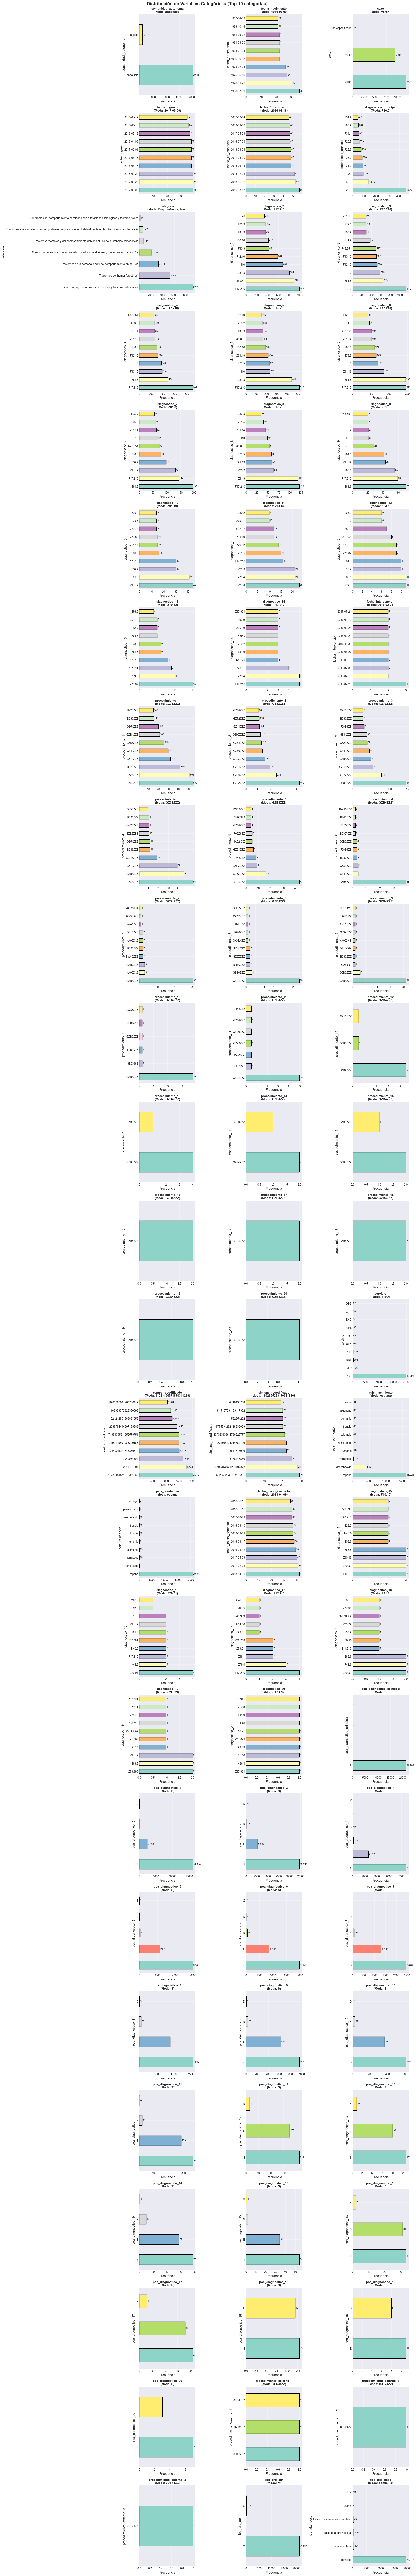


✅ Análisis completado para 78 variables categóricas


In [49]:
# ============================================================================
# ESTUDIO GENERAL DE VARIABLES CATEGÓRICAS (SOLO TIPO OBJECT Y CATEGORY)
# ============================================================================

def analisis_general_categoricas(df, max_categorias_mostrar=10):
    """
    Realiza un estudio completo de todas las variables categóricas del dataset
    (solo tipo object y category, excluyendo numéricas)
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame a analizar
    max_categorias_mostrar : int, default=10
        Número máximo de categorías a mostrar en detalle por variable
    
    Retorna:
    --------
    dict : Diccionario con el análisis completo de cada variable categórica
    """
    print("📊 ESTUDIO GENERAL DE VARIABLES CATEGÓRICAS")
    print("="*80)
    
    # Identificar SOLO variables categóricas (object y category)
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"\n📋 VARIABLES CATEGÓRICAS IDENTIFICADAS: {len(categorical_columns)}")
    print("="*80)
    
    if len(categorical_columns) == 0:
        print("⚠️ No se encontraron variables categóricas en el dataset")
        return {}
    
    resultados = {}
    
    for col in categorical_columns:
        print(f"\n🏷️ VARIABLE: {col}")
        print("-"*80)
        
        # Contar frecuencias
        value_counts = df[col].value_counts()
        total_registros = len(df)
        registros_validos = df[col].notna().sum()
        registros_nulos = df[col].isna().sum()
        
        # Calcular moda (puede haber múltiples modas)
        moda = df[col].mode()
        
        # Información general
        print(f"📈 INFORMACIÓN GENERAL:")
        print(f"   • Tipo de dato: {df[col].dtype}")
        print(f"   • Total de registros: {total_registros:,}")
        print(f"   • Registros válidos: {registros_validos:,} ({registros_validos/total_registros*100:.2f}%)")
        print(f"   • Registros nulos: {registros_nulos:,} ({registros_nulos/total_registros*100:.2f}%)")
        print(f"   • Categorías únicas: {df[col].nunique()}")
        
        # Moda
        print(f"\n🎯 MODA:")
        if len(moda) == 1:
            moda_valor = moda.iloc[0]
            moda_frecuencia = value_counts.iloc[0]
            moda_porcentaje = (moda_frecuencia / registros_validos * 100) if registros_validos > 0 else 0
            print(f"   • Valor: '{moda_valor}'")
            print(f"   • Frecuencia: {moda_frecuencia:,} ({moda_porcentaje:.2f}%)")
        else:
            print(f"   • Distribución multimodal ({len(moda)} modas):")
            for i, m in enumerate(moda.head(3), 1):
                freq = value_counts.get(m, 0)
                pct = (freq / registros_validos * 100) if registros_validos > 0 else 0
                print(f"     {i}. '{m}': {freq:,} ({pct:.2f}%)")
        
        # Distribución de frecuencias
        print(f"\n📊 DISTRIBUCIÓN DE FRECUENCIAS:")
        
        # Mostrar las categorías más frecuentes
        n_mostrar = min(max_categorias_mostrar, len(value_counts))
        
        for i, (categoria, frecuencia) in enumerate(value_counts.head(n_mostrar).items(), 1):
            porcentaje = (frecuencia / registros_validos * 100) if registros_validos > 0 else 0
            barra = "█" * int(porcentaje / 2)  # Barra visual
            print(f"   {i:2d}. {str(categoria)[:50]:<50} | {frecuencia:>7,} ({porcentaje:>5.2f}%) {barra}")
        
        # Si hay más categorías, mostrar resumen
        if len(value_counts) > max_categorias_mostrar:
            otras_categorias = len(value_counts) - max_categorias_mostrar
            otras_frecuencia = value_counts.iloc[max_categorias_mostrar:].sum()
            otras_porcentaje = (otras_frecuencia / registros_validos * 100) if registros_validos > 0 else 0
            print(f"   ... y {otras_categorias} categorías más con {otras_frecuencia:,} registros ({otras_porcentaje:.2f}%)")
        
        # Estadísticas adicionales
        print(f"\n📐 ESTADÍSTICAS ADICIONALES:")
        
        # Concentración (Índice de Herfindahl-Hirschman)
        proporciones = value_counts / registros_validos if registros_validos > 0 else pd.Series()
        hhi = (proporciones ** 2).sum() if len(proporciones) > 0 else 0
        print(f"   • Índice de concentración (HHI): {hhi:.4f}")
        if hhi > 0.5:
            print(f"     └─ Interpretación: Alta concentración (distribución muy desigual)")
        elif hhi > 0.15:
            print(f"     └─ Interpretación: Concentración moderada")
        else:
            print(f"     └─ Interpretación: Baja concentración (distribución uniforme)")
        
        # Entropía (diversidad)
        entropia_normalizada = 0
        if registros_validos > 0 and len(proporciones) > 0:
            entropia = -(proporciones * np.log2(proporciones + 1e-10)).sum()
            max_entropia = np.log2(len(proporciones))
            entropia_normalizada = entropia / max_entropia if max_entropia > 0 else 0
            print(f"   • Entropía normalizada: {entropia_normalizada:.4f}")
            print(f"     └─ Interpretación: {'Alta diversidad' if entropia_normalizada > 0.8 else 'Diversidad moderada' if entropia_normalizada > 0.5 else 'Baja diversidad'}")
        
        # Almacenar resultados
        resultados[col] = {
            'tipo_dato': str(df[col].dtype),
            'total_registros': total_registros,
            'registros_validos': registros_validos,
            'registros_nulos': registros_nulos,
            'porcentaje_nulos': (registros_nulos/total_registros*100) if total_registros > 0 else 0,
            'categorias_unicas': df[col].nunique(),
            'moda': moda.tolist(),
            'moda_frecuencia': value_counts.iloc[0] if len(value_counts) > 0 else 0,
            'moda_porcentaje': (value_counts.iloc[0]/registros_validos*100) if registros_validos > 0 and len(value_counts) > 0 else 0,
            'value_counts': value_counts,
            'hhi': hhi,
            'entropia_normalizada': entropia_normalizada
        }
    
    # Resumen general
    print("\n" + "="*80)
    print("📋 RESUMEN GENERAL DE VARIABLES CATEGÓRICAS")
    print("="*80)
    
    resumen_df = pd.DataFrame({
        'Variable': list(resultados.keys()),
        'Tipo': [resultados[col]['tipo_dato'] for col in resultados],
        'Categorías_Únicas': [resultados[col]['categorias_unicas'] for col in resultados],
        'Moda': [str(resultados[col]['moda'][0])[:30] if len(resultados[col]['moda']) > 0 else 'N/A' for col in resultados],
        'Frecuencia_Moda': [resultados[col]['moda_frecuencia'] for col in resultados],
        '%_Moda': [f"{resultados[col]['moda_porcentaje']:.2f}%" for col in resultados],
        '%_Nulos': [f"{resultados[col]['porcentaje_nulos']:.2f}%" for col in resultados],
        'Concentración_HHI': [f"{resultados[col]['hhi']:.4f}" for col in resultados]
    })
    
    print("\n" + resumen_df.to_string(index=False))
    
    # Visualización general
    if len(categorical_columns) > 0:
        n_vars = len(categorical_columns)
        n_cols = min(3, n_vars)
        n_rows = (n_vars + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 5*n_rows))
        fig.suptitle('Distribución de Variables Categóricas (Top 10 categorías)', 
                     fontsize=16, fontweight='bold', y=0.998)
        
        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        for idx, col in enumerate(categorical_columns):
            row = idx // n_cols
            col_idx = idx % n_cols
            ax = axes[row, col_idx]
            
            value_counts = resultados[col]['value_counts'].head(10)
            
            colors = plt.cm.Set3(np.linspace(0, 1, len(value_counts)))
            value_counts.plot(kind='barh', ax=ax, color=colors, edgecolor='black')
            
            moda_texto = str(resultados[col]["moda"][0])[:20]
            ax.set_title(f'{col}\n(Moda: {moda_texto})', 
                        fontweight='bold', fontsize=11)
            ax.set_xlabel('Frecuencia')
            ax.grid(axis='x', alpha=0.3)
            
            # Añadir valores en las barras
            for i, (categoria, valor) in enumerate(value_counts.items()):
                ax.text(valor + max(value_counts)*0.01, i, f'{valor:,}', 
                       va='center', fontsize=9)
        
        # Ocultar ejes sobrantes
        for idx in range(len(categorical_columns), n_rows * n_cols):
            row = idx // n_cols
            col_idx = idx % n_cols
            axes[row, col_idx].axis('off')
        
        plt.tight_layout()
        plt.savefig('analisis_general_categoricas.png', dpi=300, bbox_inches='tight')
        print(f"\n💾 Gráfico guardado: 'analisis_general_categoricas.png'")
        plt.show()
    
    print(f"\n✅ Análisis completado para {len(categorical_columns)} variables categóricas")
    
    return resultados

# Ejecutar análisis (SOLO variables categóricas tipo object y category)
resultados_categoricas = analisis_general_categoricas(df, max_categorias_mostrar=10)

### Detección de Valores Nulos

🔍 ANÁLISIS DE VALORES NULOS EN VARIABLES CATEGÓRICAS


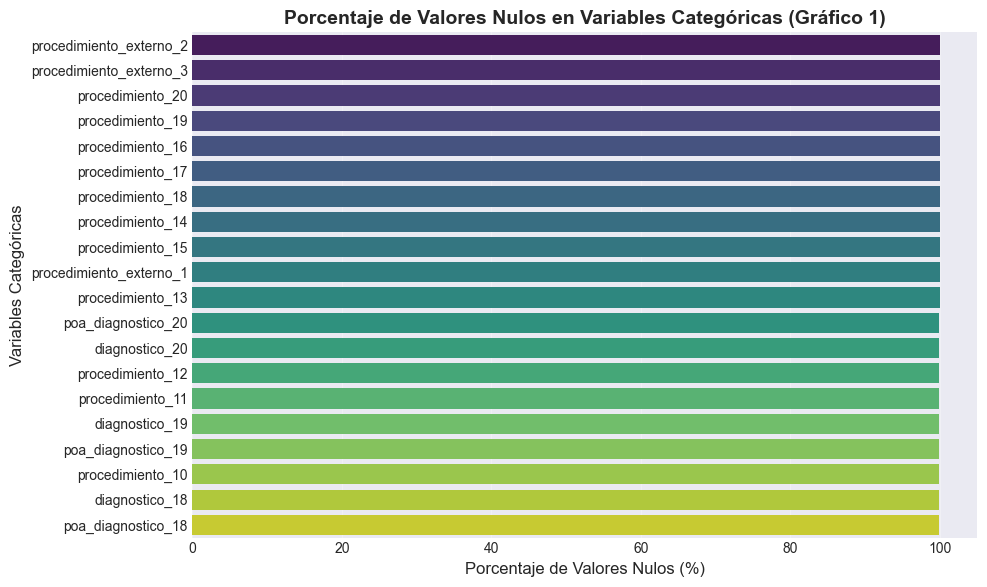

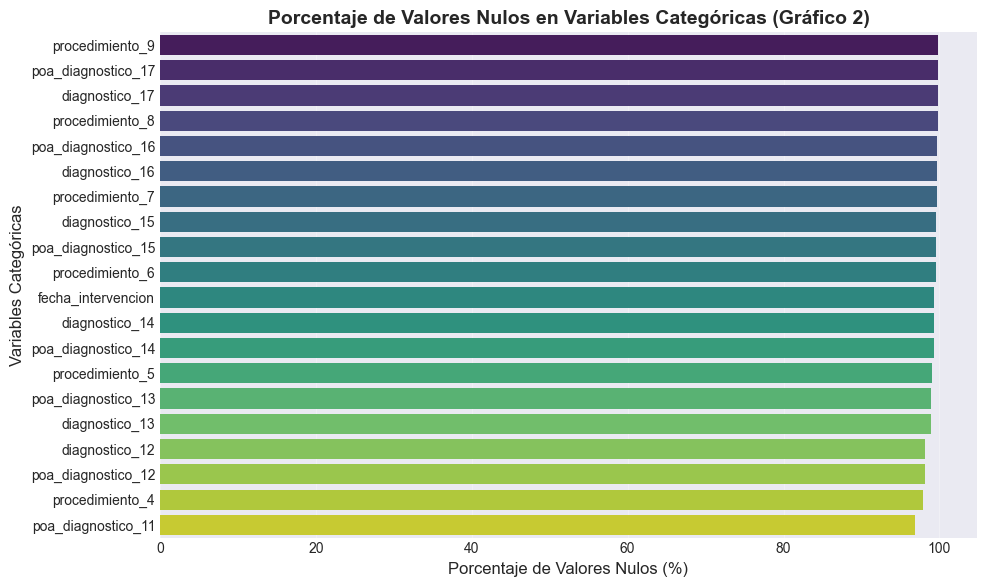

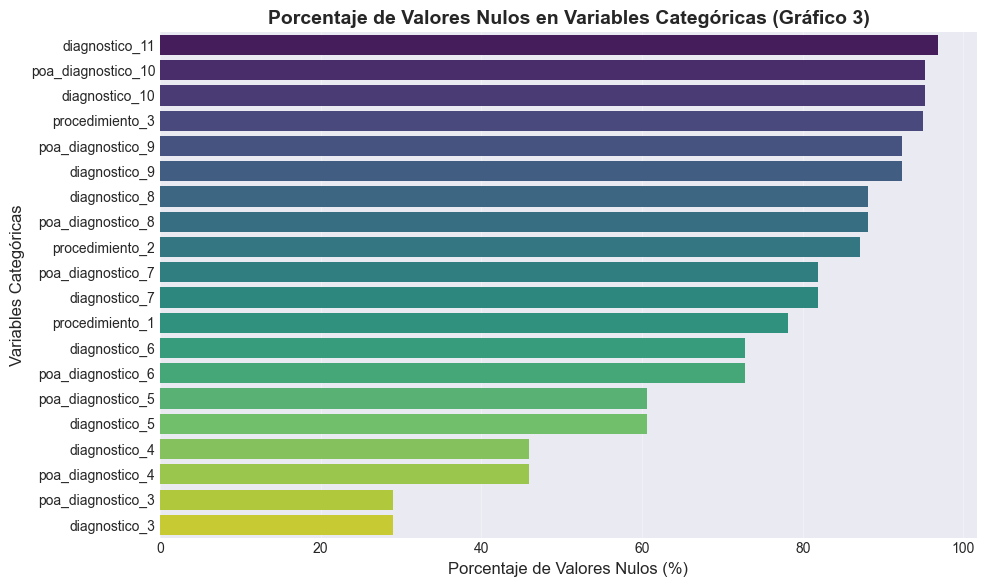

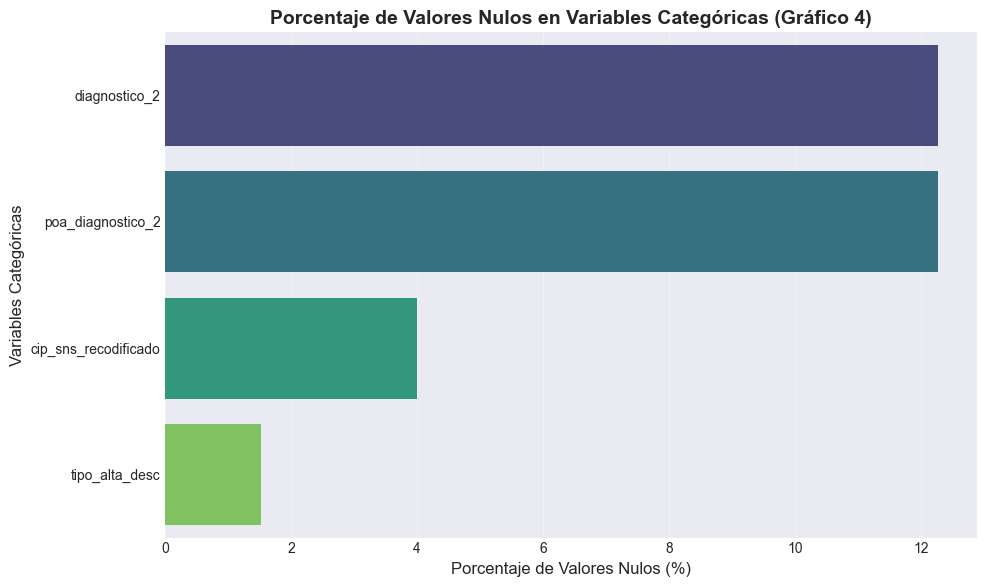


📊 RESUMEN DE VALORES NULOS EN VARIABLES CATEGÓRICAS:
   • Total de variables categóricas: 78
   • Variables con >0% nulos: 64
   • Gráficos generados: 4

📋 COLUMNAS CATEGÓRICAS FILTRADAS (≤70% nulos):
   • Total: 24
   • comunidad_autonoma: 0.00% nulos
   • fecha_nacimiento: 0.00% nulos
   • sexo: 0.00% nulos
   • fecha_ingreso: 0.00% nulos
   • fecha_fin_contacto: 0.00% nulos
   • diagnostico_principal: 0.00% nulos
   • categoria: 0.00% nulos
   • diagnostico_2: 12.28% nulos
   • diagnostico_3: 29.00% nulos
   • diagnostico_4: 45.87% nulos
   • diagnostico_5: 60.65% nulos
   • servicio: 0.00% nulos
   • centro_recodificado: 0.00% nulos
   • cip_sns_recodificado: 4.00% nulos
   • pais_nacimiento: 0.00% nulos
   • pais_residencia: 0.00% nulos
   • fecha_inicio_contacto: 0.00% nulos
   • poa_diagnostico_principal: 0.00% nulos
   • poa_diagnostico_2: 12.28% nulos
   • poa_diagnostico_3: 29.00% nulos
   • poa_diagnostico_4: 45.87% nulos
   • poa_diagnostico_5: 60.65% nulos
   • tipo_grd_a

In [52]:
# ============================================================================
# DETECCIÓN DE VALORES NULOS EN VARIABLES CATEGÓRICAS
# ============================================================================

def plot_missing_values_categorical(df, threshold=0):
    """
    Genera gráficos de columnas categóricas con valores nulos según un umbral de porcentaje.
    
    Args:
        df (DataFrame): Dataset a analizar.
        threshold (int): Porcentaje de valores nulos a partir del cual se consideran relevantes.
    """
    # Seleccionar solo columnas categóricas (object y category)
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # Calcular valores nulos solo para columnas categóricas
    missing_values = df[categorical_columns].isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_data = missing_percentage[missing_percentage > threshold].sort_values(ascending=False)
    
    if len(missing_data) == 0:
        print(f"✅ No hay variables categóricas con más de {threshold}% de valores nulos")
        return

    # Dividir las columnas en grupos para mejorar la visualización
    columns_per_plot = 20  # Número de columnas por gráfico
    num_plots = (len(missing_data) + columns_per_plot - 1) // columns_per_plot  # Calcular número de gráficos

    for i in range(num_plots):
        start_idx = i * columns_per_plot
        end_idx = start_idx + columns_per_plot
        subset_missing_data = missing_data.iloc[start_idx:end_idx]
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=subset_missing_data.values, y=subset_missing_data.index, 
                   palette="viridis", hue=subset_missing_data.index, dodge=False, legend=False)
        plt.title(f"Porcentaje de Valores Nulos en Variables Categóricas (Gráfico {i + 1})", 
                 fontsize=14, fontweight="bold")
        plt.xlabel("Porcentaje de Valores Nulos (%)")
        plt.ylabel("Variables Categóricas")
        plt.tight_layout()
        plt.savefig(f"valores_nulos_categoricas_{i + 1}.png")
        plt.show()
    
    # Imprimir resumen
    print(f"\n📊 RESUMEN DE VALORES NULOS EN VARIABLES CATEGÓRICAS:")
    print(f"   • Total de variables categóricas: {len(categorical_columns)}")
    print(f"   • Variables con >{threshold}% nulos: {len(missing_data)}")
    print(f"   • Gráficos generados: {num_plots}")

# ============================================================================
# FILTRADO DE VARIABLES CATEGÓRICAS POR PORCENTAJE DE NULOS
# ============================================================================

def filter_categorical_columns_by_nulls(df, max_null_percentage):
    """
    Filtra columnas categóricas con un porcentaje de valores nulos menor al umbral especificado.

    Args:
        df (pd.DataFrame): DataFrame que contiene las columnas categóricas.
        max_null_percentage (float): Porcentaje máximo de valores nulos permitido (0-100).

    Returns:
        list: Lista de columnas categóricas que cumplen con el criterio.
    """
    # Seleccionar columnas categóricas (object y category)
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # Filtrar columnas según el porcentaje de valores nulos
    filtered_columns = [
        col for col in categorical_columns
        if (df[col].isnull().sum() / len(df)) * 100 <= max_null_percentage
    ]
    
    return filtered_columns

# Configurar umbral
threshold_categorical = 70

# Identificar columnas categóricas con valores nulos y calcular el porcentaje
print("🔍 ANÁLISIS DE VALORES NULOS EN VARIABLES CATEGÓRICAS")
print("="*70)

# Llamar a la función con el umbral deseado
plot_missing_values_categorical(df, threshold=0)

# Filtrar columnas categóricas con bajo porcentaje de nulos
columnas_categoricas_filtradas = filter_categorical_columns_by_nulls(df, max_null_percentage=threshold_categorical)

print(f"\n📋 COLUMNAS CATEGÓRICAS FILTRADAS (≤{threshold_categorical}% nulos):")
print(f"   • Total: {len(columnas_categoricas_filtradas)}")
if len(columnas_categoricas_filtradas) > 0:
    for col in columnas_categoricas_filtradas:
        null_pct = (df[col].isnull().sum() / len(df)) * 100
        print(f"   • {col}: {null_pct:.2f}% nulos")